## PRISM data not concatenating correctly for all sites

## Processing Sensor Data from Catalina Jemez CZO MC Pit 1
- Marc Berghouse 9/19/2020: original format
- Zach Perzan 9/23/2020: improved format and working PRISM concat

This array includes:
- apogee_SO110
- Vaisala_GMM220
- DecagonMPS2
- Decagon5TE
- Vertical Redox probes from Paleo Terra

Issues:
- I'm not sure which water potential values are unrealistic
- Unsure about O2 mask


In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

def plot_cols(column_list, ylabel=''):
    """Plot columns from df. Columns to plot must be in
    column_list."""
    
    n = len(column_list)

    fig, ax = plt.subplots(n, figsize=(10,3*n), tight_layout=True, sharex=True)

    for i, col in enumerate(column_list):
        ax[i].plot(df.index, df[col], label=col)
        ax[i].legend(loc='upper right')
        ax[i].set(ylabel=ylabel)
        
    return fig, ax

In [2]:
# Import each file individually as a dataframe and append it to a list of dataframes

infiles = ["../../raw_data/Catalina-Jemez/MC_Pit1/mc_pit1_2010.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit1/mc_pit1_2011.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit1/mc_pit1_2012.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit1/mc_pit1_2013.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit1/mc_pit1_2014.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit1/mc_pit1_2015.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit1/mc_pit1_2016.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit1/mc_pit1_2018.csv",
           "../../raw_data/Catalina-Jemez/MC_Pit1/MC1co2o2_2013.csv",  
           "../../raw_data/Catalina-Jemez/MC_Pit1/MC1co2o2_2014.csv",  
           "../../raw_data/Catalina-Jemez/MC_Pit1/MC1co2o2_2015.csv",  
           "../../raw_data/Catalina-Jemez/MC_Pit1/MC1co2o2_2016.csv",  
           "../../raw_data/Catalina-Jemez/MC_Pit1/MC1co2o2_2017.csv",  
           "../../raw_data/Catalina-Jemez/MC_Pit1/Redox_MC_Pit1_2015.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit1/Redox_MC_Pit1_2016.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit1/Redox_MC_Pit1_2017.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit1/Redox_MC_Pit1_2018.csv"]

# Lists of all dataframes
df_list = []

for infile in tqdm(infiles):
    df = pd.read_csv(infile, na_values=['NAN', -9999],  parse_dates=[0], 
                     index_col=0, skiprows=[1]) # skiprows=[1] skips the 1th row (0-indexed)
    df_list.append(df)
    
prism_path = "../../raw_data/Catalina-Jemez/Catalina-Jemez_MC_PRISM.csv"
ppt = pd.read_csv(prism_path, na_values=['NAN',-9999,-99999], skiprows=11, 
                  parse_dates=[0], index_col=0, names=['PRISM_precip.mm']) 
ppt['PRISM_precip.mm'] = pd.to_numeric(ppt['PRISM_precip.mm'])

In [3]:
columns=['SoilMoisture_12cm.m3m3', 'Decagon5TETemp_12cm.deg.C', 'BulkEC_12cm.dS/m',
            'SoilMoisture_37cm.m3m3', 'Decagon5TETemp_37cm.deg.C', 'BulkEC_37cm.dS/m',
            'SoilMoisture_57cm.m3m3', 'Decagon5TETemp_57cm.deg.C', 'BulkEC_57cm.dS/m',
            'Voltage_12cm.mV', 'Voltage_23cm.mV', 'ApogeeTemp_2cm.deg.C','ApogeeTemp_10cm.deg.C',
            'ApogeeTemp_30cm.deg.C', 'ApogeeTemp_60cm.deg.C', 'O2_2cm.percent.0-100', 
            'O2_10cm.percent.0-100', 'O2_30cm.percent.0-100', 'O2_60cm.percent.0-100',
            'CO2_2cm.ppm', 'CO2_10cm.ppm', 'CO2_30cm.ppm', 'CO2_60cm.ppm', 
            'ReductionPotential_5cm.mV','ReductionPotential_10cm.mV','ReductionPotential_30cm.mV',
            'ReductionPotential_60cm.mV',]

# Concatenate all individual files to a single dataframe
df = pd.concat(df_list)
df.columns = columns

# Resample everything to hourly averages since certain 
# sensors are measured on different schedules
df.sort_index(inplace=True) # Sort first
df = df.resample('1H').mean()
df
# Add on up-sampled PRISM data
# (resample daily to hourly, using the nearest value, then
#  add on as new column to df)
hourly_ppt = ppt.resample('1H').nearest()
df.loc[hourly_ppt.index, 'PRISM_precip.mm'] = hourly_ppt['PRISM_precip.mm']

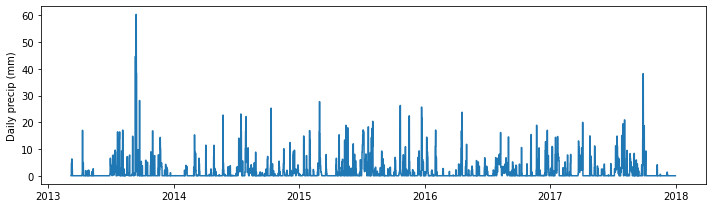

In [4]:
# Plot precip data
fig, ax = plt.subplots(figsize=(10,3), tight_layout=True)

ax.plot(df.index, df['PRISM_precip.mm'])
ax.set(ylabel='Daily precip (mm)');

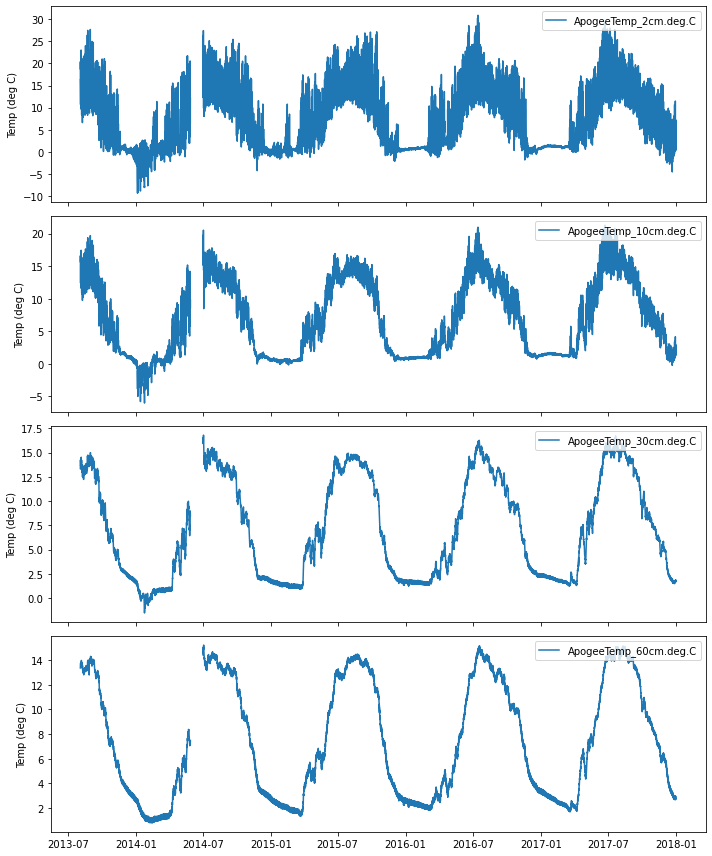

In [5]:
# Plot apogee thermistor temperature
apogee_temp_cols = [col for col in df.columns if 'ApogeeTemp' in col]
plot_cols(apogee_temp_cols, ylabel='Temp (deg C)');

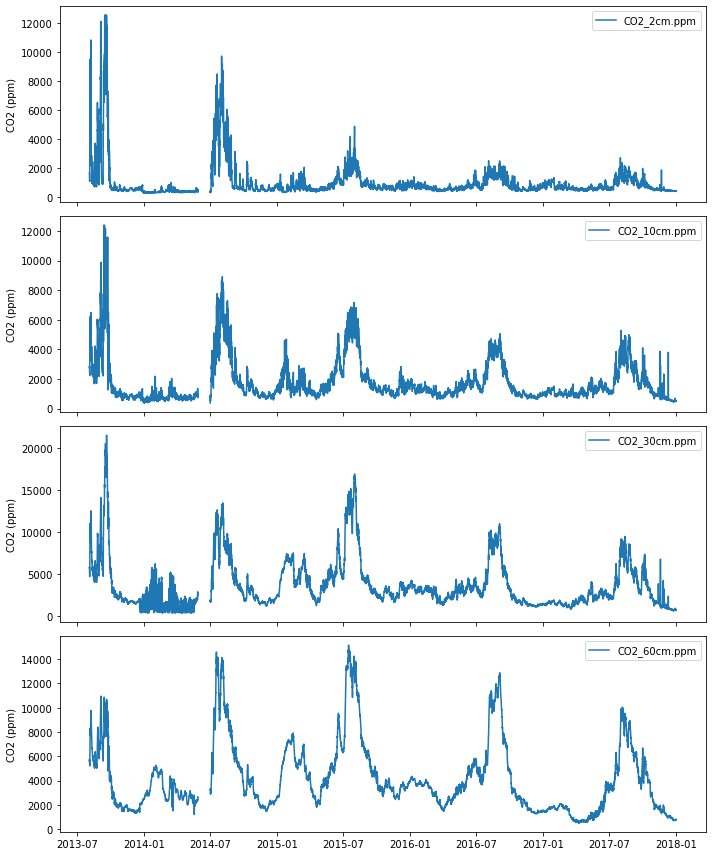

In [6]:
# Plot CO2 data
co2_cols = [col for col in df.columns if 'CO2' in col]
plot_cols(co2_cols, ylabel='CO2 (ppm)');

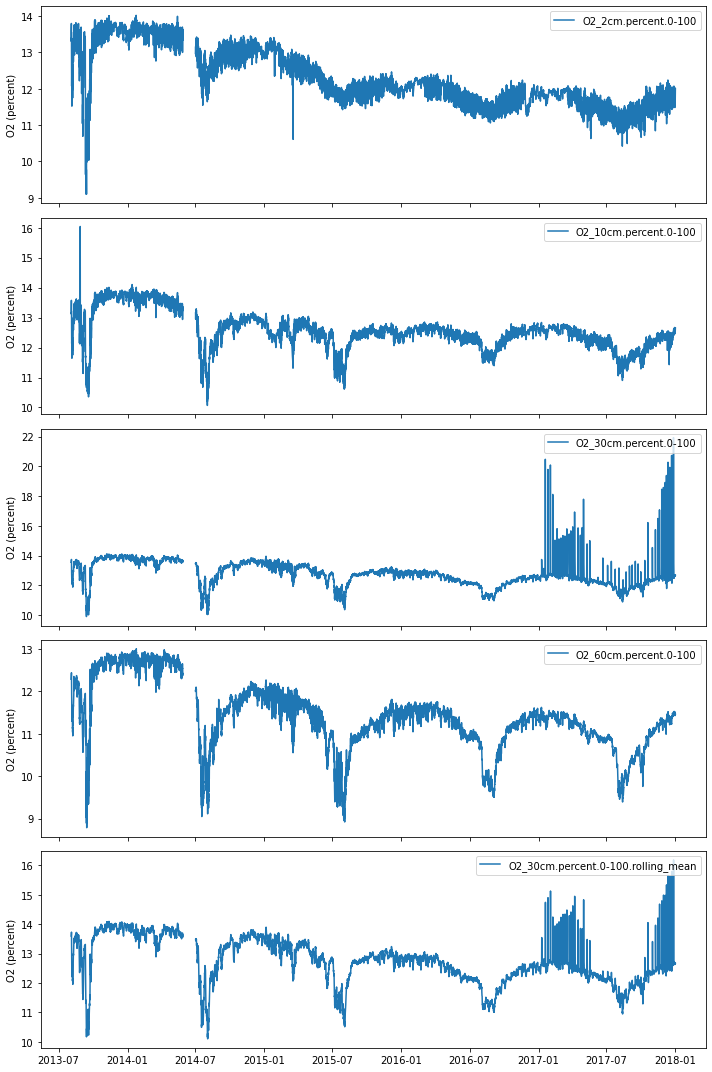

In [7]:
# Plot O2 data
df['O2_30cm.percent.0-100.rolling_mean']=df['O2_30cm.percent.0-100'].rolling(8).mean()

o2_cols = [col for col in df.columns if col[:2] == 'O2']
plot_cols(o2_cols, ylabel='O2 (percent)');

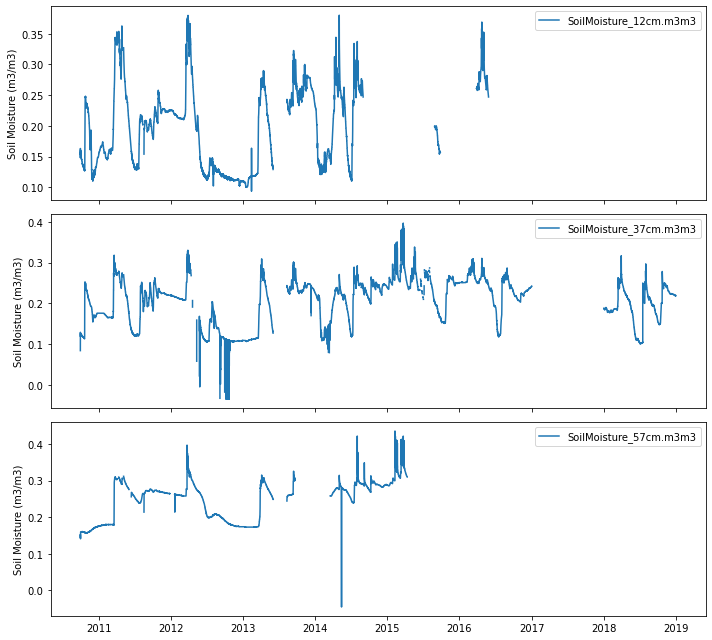

In [9]:
# Plot soil moisture data
sm_cols = [col for col in df.columns if 'SoilMoisture' in col]
plot_cols(sm_cols, ylabel='Soil Moisture (m3/m3)');

In [17]:
print(sm_df)

                     SoilMoisture_12cm.m3m3  SoilMoisture_37cm.m3m3  \
2010-09-29 11:00:00                0.155200                0.084000   
2010-09-29 12:00:00                0.153833                0.093833   
2010-09-29 13:00:00                0.148000                0.126500   
2010-09-29 14:00:00                0.152833                0.128167   
2010-09-29 15:00:00                0.153000                0.129000   
...                                     ...                     ...   
2018-12-31 19:00:00                     NaN                0.219000   
2018-12-31 20:00:00                     NaN                0.219000   
2018-12-31 21:00:00                     NaN                0.219000   
2018-12-31 22:00:00                     NaN                0.219000   
2018-12-31 23:00:00                     NaN                0.219000   

                     SoilMoisture_57cm.m3m3  
2010-09-29 11:00:00                0.145200  
2010-09-29 12:00:00                0.153000  
2010-09-2

[Text(0.5, 0, 'Soil moisture (m$^3$/m$^3$)'),
 Text(0, 0.5, 'Depth (cm)'),
 (60.0, 0.0)]

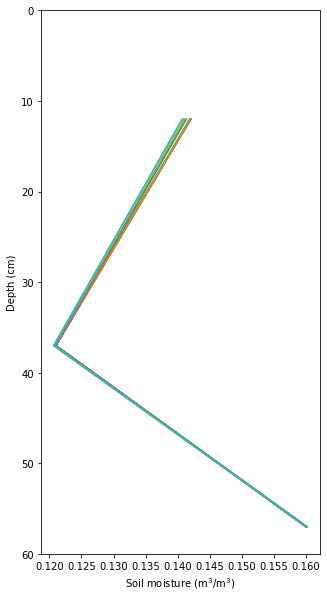

In [22]:
sm_df = df[[col for col in df.columns if 'SoilMoisture' in col]]
fig, ax = plt.subplots(figsize=(5,10))

for i in range(20):
#     j = np.random.randint(sm_df.shape[0])
    ax.plot(sm_df.iloc[i+200, :], [12, 37, 57])
    
ax.set(xlabel='Soil moisture (m$^3$/m$^3$)', ylabel="Depth (cm)", ylim=[60,0])

12    0.197140
37    0.205100
57    0.247635
dtype: float64

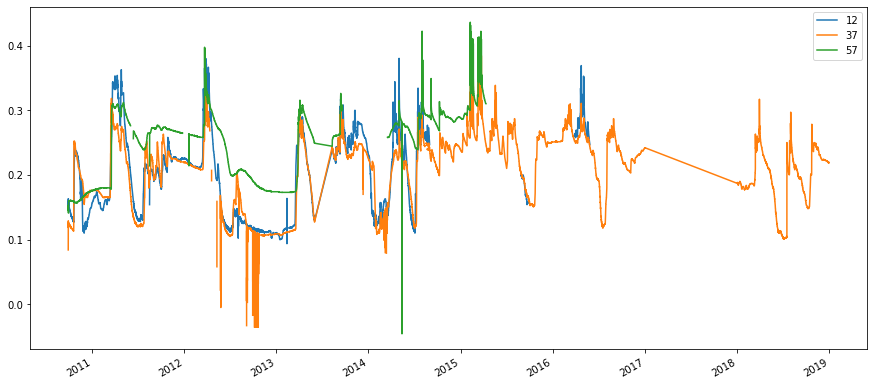

In [8]:
#Determine relationship between soil moisture and depth
df12=df['SoilMoisture_12cm.m3m3']
df37=df['SoilMoisture_37cm.m3m3']
df57=df['SoilMoisture_57cm.m3m3']
pieces = {12: df12, 37: df37, 57: df57}
depth_df=pd.concat(pieces, join='inner', keys=[12, 37, 57])
depth_df=depth_df[depth_df<2]
time_group=depth_df.groupby(level=1)
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
depth_df.groupby(level=(1,0)).mean().unstack().plot(ax=ax)
depth_df.groupby(level=(0)).mean()

In [9]:
df=df.drop(columns='SoilMoisture_37cm.m3m3')

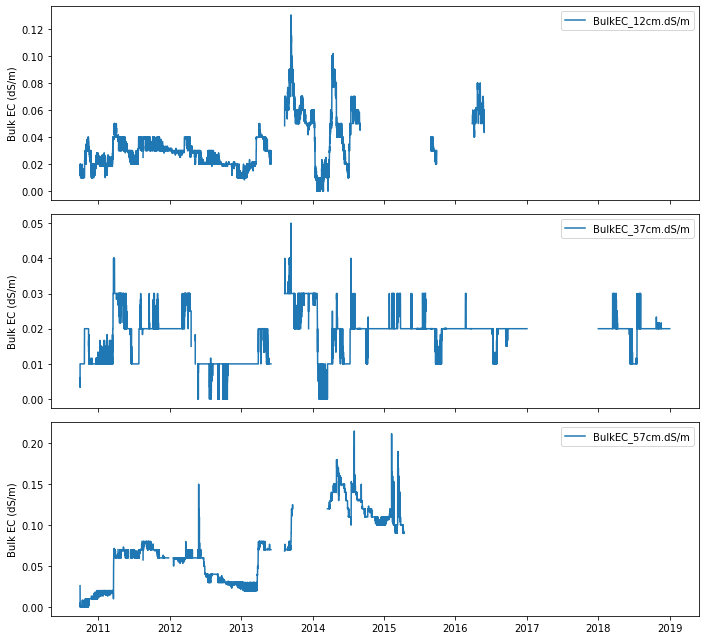

In [10]:
# Plot bulk EC
ec_cols = [col for col in df.columns if 'BulkEC' in col]
plot_cols(ec_cols, ylabel='Bulk EC (dS/m)');

12    0.033610
37    0.018157
57    0.068652
dtype: float64

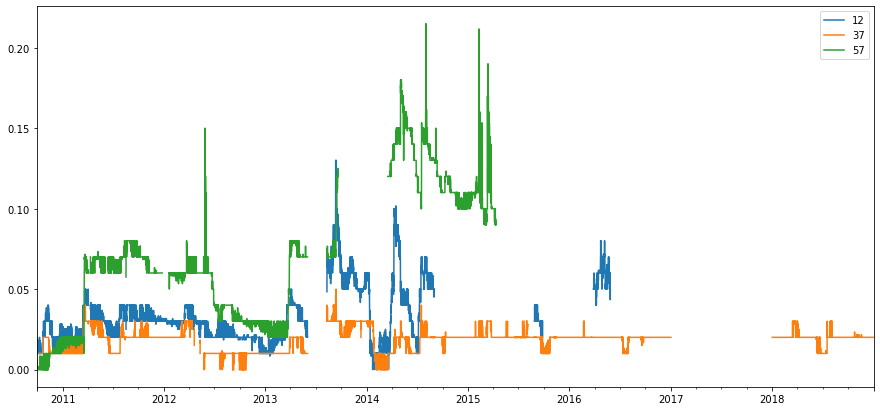

In [77]:
#determine relationship between bulk EC and depth
df12_EC=df['BulkEC_12cm.dS/m']
df37_EC=df['BulkEC_37cm.dS/m']
df57_EC=df['BulkEC_57cm.dS/m']
pieces_EC = {12: df12_EC, 37: df37_EC, 57: df57_EC}
depth_df_EC=pd.concat(pieces_EC, join='inner')#, keys=[12, 37, 57])
#depth_df_EC=depth_df[depth_df<2]
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
depth_df_EC.groupby(level=(1,0)).mean().unstack().plot(ax=ax)
depth_df_EC.groupby(level=(0)).mean()

In [11]:
df=df.drop(columns='BulkEC_37cm.dS/m')

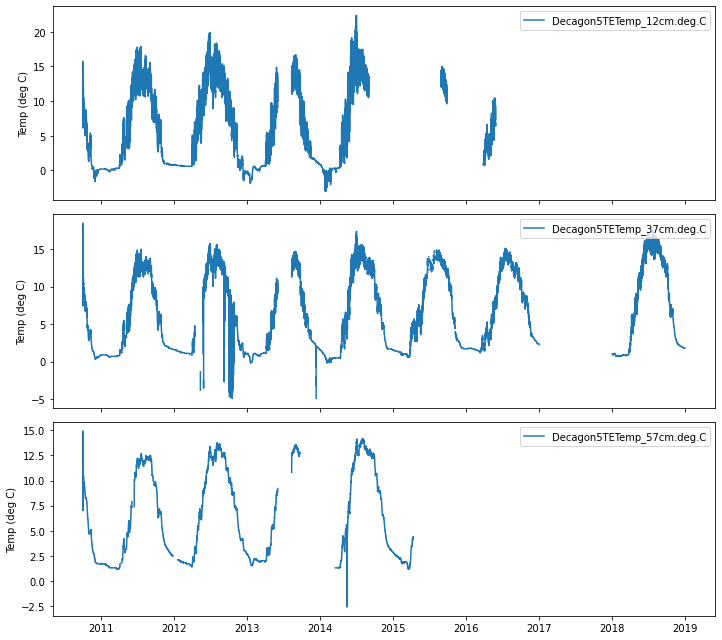

In [12]:
# Plot soil temperature from Decagon 5TE
dec_temp_cols = [col for col in df.columns if 'Decagon5TETemp' in col]

# There are several erroneous values less than -5 deg C
for col in dec_temp_cols:
    df[df[col] < -5] = np.nan
plot_cols(dec_temp_cols, ylabel='Temp (deg C)');

In [13]:
df=df.drop(columns='Decagon5TETemp_12cm.deg.C')
df=df.drop(columns='Decagon5TETemp_37cm.deg.C')
df=df.drop(columns='Decagon5TETemp_57cm.deg.C')
df=df.drop(columns='Voltage_12cm.mV')
df=df.drop(columns='Voltage_23cm.mV')

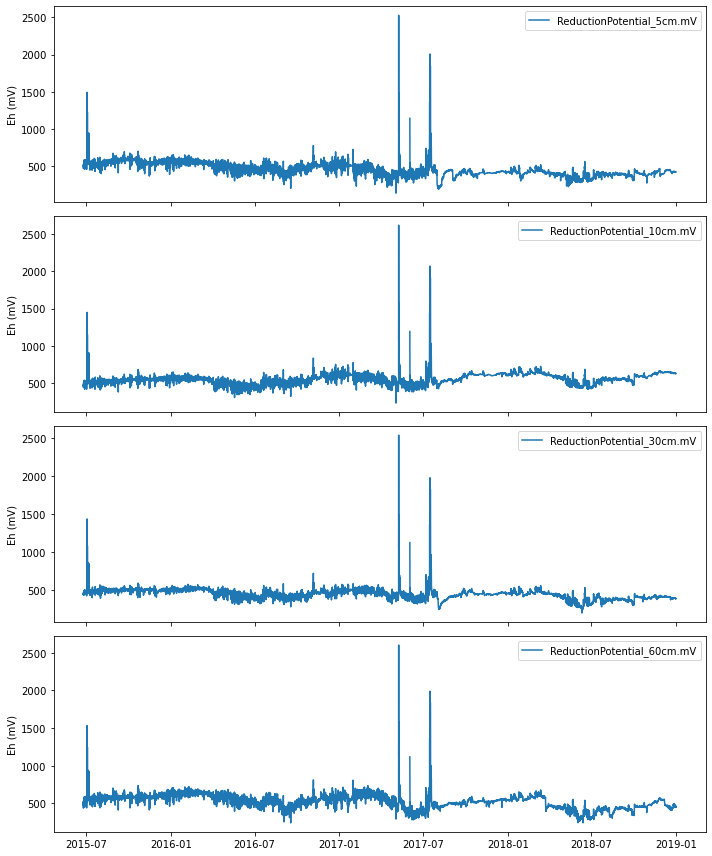

In [14]:
# Plot redox potential
eh_cols = [col for col in df.columns if 'ReductionPotential' in col]
plot_cols(eh_cols, ylabel='Eh (mV)');

In [15]:
output=df.copy()
outfile = '../../processed_data/Catalina-Jemez/MC_Pit1_processed.csv'
output.to_csv(outfile, na_rep=-99999, index_label='DateTime.MST')

In [16]:
output

,SoilMoisture_12cm.m3m3,BulkEC_12cm.dS/m,SoilMoisture_57cm.m3m3,BulkEC_57cm.dS/m,ApogeeTemp_2cm.deg.C,ApogeeTemp_10cm.deg.C,ApogeeTemp_30cm.deg.C,ApogeeTemp_60cm.deg.C,O2_2cm.percent.0-100,O2_10cm.percent.0-100,...,CO2_2cm.ppm,CO2_10cm.ppm,CO2_30cm.ppm,CO2_60cm.ppm,ReductionPotential_5cm.mV,ReductionPotential_10cm.mV,ReductionPotential_30cm.mV,ReductionPotential_60cm.mV,PRISM_precip.mm,O2_30cm.percent.0-100.rolling_mean
2010-09-29 11:00:00,0.155200,0.018,0.145200,0.026,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-29 12:00:00,0.153833,0.020,0.153000,0.025,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-29 13:00:00,0.148000,0.020,0.149500,0.010,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-29 14:00:00,0.152833,0.020,0.152000,0.010,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-29 15:00:00,0.153000,0.020,0.151833,0.010,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,423.750,628.300,383.675,462.475,NaN,NaN
2018-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,423.825,628.750,384.075,459.000,NaN,NaN
2018-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,423.975,628.925,384.225,458.675,NaN,NaN
2018-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,423.500,629.000,384.925,457.350,NaN,NaN
